In [83]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

#from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn import linear_model

random_param_test = 3
random_param_cv = 13

from sklearn.metrics import mean_absolute_error



In [84]:
df_full = pd.read_csv('student-por.csv', sep = ';')


In [85]:
df_full.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [86]:
df_full.shape

(649, 33)

In [87]:
## To do later:

## 1
#Dropping outliers: 
#Remove the 15 students who did not take the G3 exam. This includes 15 students, or 2.3% of the total population.

df_drop_outliers = df_full.loc[ df_full['G3'] != 0 ]

display(df_drop_outliers.shape)





## 2
# Keep selected subset of columns only
# Improve interpretabliltiy by running the model with only the important features

my_cols = ['school','sex','failures','higher','Medu','Fedu','G3']
df_subset = df_full[my_cols].copy()

df_subset.head(10)






(634, 33)

,school,sex,failures,higher,Medu,Fedu,G3
0,GP,F,0,yes,4,4,11
1,GP,F,0,yes,1,1,11
2,GP,F,0,yes,1,1,12
3,GP,F,0,yes,4,2,14
4,GP,F,0,yes,3,3,13
5,GP,M,0,yes,4,3,13
6,GP,M,0,yes,2,2,13
7,GP,F,0,yes,4,4,13
8,GP,M,0,yes,3,2,17
9,GP,M,0,yes,3,4,13


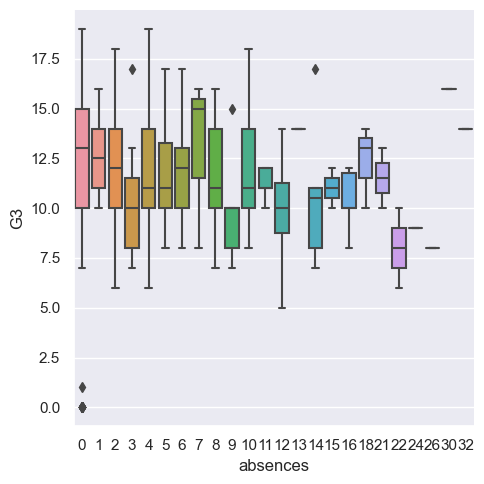

In [88]:
#absences is a high cardinality categorical feature, as can be seen by the following box and whisker plot.

sns.catplot(data=df_full, x="absences", y="G3", kind="box" )


In [89]:
# To make this feature usable by the modeling algorithms, we will bin absences.
# We see that mosts students have 0 absences. 

df_full['absences'].value_counts()

0     244
2     110
4      93
6      49
8      42
10     21
1      12
12     12
5      12
16     10
14      8
9       7
3       7
11      5
18      3
7       3
21      2
15      2
22      2
30      1
26      1
24      1
13      1
32      1
Name: absences, dtype: int64

In [90]:
# Since 244 students have 0 absences, we will choose to have 3 bins of size about 200.
# Define the function for binning:

def get_absences(N):
    
    if N == 0 :
        return 1
        
    elif N>0 and N<5 :
        return 2
    
    else:
        return 3

In [91]:
# Create a new feature 'absences_bin' that takes the three values:
# absences_bin = 1 if absences = 0
# absences_bin = 2 if absences = 1,2,3, or 4
# absences_bin = 3 if absences > 4

df_full['absences_bin'] = df_full['absences'].apply(get_absences)


In [92]:
# We see that the size of the bins are approximately 200

df_full['absences_bin'].value_counts()

1    244
2    222
3    183
Name: absences_bin, dtype: int64

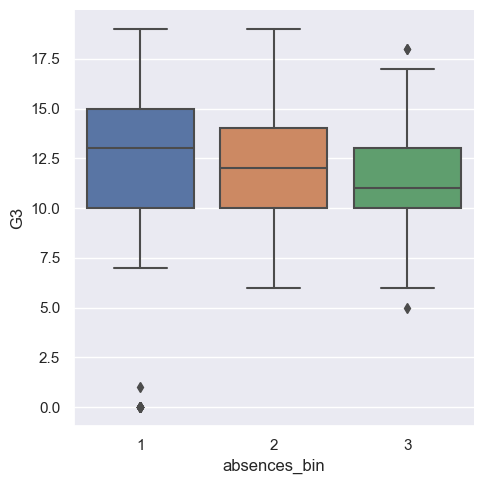

In [93]:
# We can also see that the behavior of the 'absences_bin' is an improvement over 'absences'. 
# The following plot shows the general trend that more absences correspont to smaller G3 exam score.

sns.catplot(data=df_full, x="absences_bin", y="G3", kind="box" )


In [94]:
df = df_full.drop(['absences'], axis=1)

In [95]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,G1,G2,G3,absences_bin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,0,11,11,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,9,11,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,12,13,12,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,14,14,14,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,11,13,13,1


In [96]:
# Separate target from predictors

y = df.G3
X = df.drop(['G1','G2','G3'], axis=1)

In [97]:
y

0      11
1      11
2      12
3      14
4      13
       ..
644    10
645    16
646     9
647    10
648    11
Name: G3, Length: 649, dtype: int64

In [98]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences_bin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,1


In [99]:
# Divide data into training and test subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)


In [100]:
X_train.shape

(519, 30)

In [101]:
y_train

27     11
43     10
130    12
294    13
136    11
       ..
422    13
119    14
256     8
643    10
249    12
Name: G3, Length: 519, dtype: int64

In [102]:
X_test.shape

(130, 30)

In [103]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

In [104]:
categorical_cols

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [105]:
len(categorical_cols)

17

In [106]:
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [107]:
numerical_cols

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences_bin']

In [108]:
len(numerical_cols)

13

In [109]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [110]:
model_Forest = RandomForestRegressor(random_state=0)

In [111]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model_Forest)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of test data, get predictions
preds = my_pipeline.predict(X_test)

# Evaluate the model
score = mean_absolute_error(y_test, preds)


In [112]:
#one-hot encoding of the categorical features
#model = RandomForestRegressor
#minimal feature engineering

#The MAE is:
display(score)

1.9049230769230767

In [113]:
#We can also cross validate using random subsets:

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=random_param_cv)


In [114]:
scores2 = cross_val_score(my_pipeline, X_train, y_train, cv=cv, scoring = 'neg_mean_absolute_error')

-scores2

array([1.85576923, 2.045     , 1.90807692, 2.31875   , 1.79288462])

In [115]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (-scores2.mean(), scores2.std()))

1.98 accuracy with a standard deviation of 0.19


In [116]:
model_LinReg_1 = linear_model.LinearRegression()

In [117]:
# Keep selected subset of columns only
# Improve interpretabliltiy by running the model with only the important features

my_cols = ['failures','G3']
df_subset_1 = df[my_cols].copy()

df_subset_1.head(10)

,failures,G3
0,0,11
1,0,11
2,0,12
3,0,14
4,0,13
5,0,13
6,0,13
7,0,13
8,0,17
9,0,13


In [118]:
# Separate target from predictors

y_subset_1 = df_subset_1.G3
X_subset_1 = df_subset_1.drop(['G3'], axis=1)


# Divide data into training and test subsets

X_train_subset_1, X_test_subset_1, y_train_subset_1, y_test_subset_1 = train_test_split(X_subset_1, y_subset_1, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)


In [119]:
X_train_subset_1.head(10)

,failures
27,0
43,0
130,0
294,0
136,0
211,0
578,1
541,0
463,0
170,3


In [120]:
model_LinReg_1.fit(X_train_subset_1, y_train_subset_1)

# Make predictions using the testing set
y_pred_subset_1 = model_LinReg_1.predict(X_test_subset_1)

# The coefficients
print("Coefficients: \n", model_LinReg_1.coef_)

# The mean absolute error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test_subset_1, y_pred_subset_1))

Coefficients: 
 [-2.27457791]
Mean absolute error: 2.17


In [121]:
pd.merge(df_subset_1, X_train_subset_1, left_index=True, right_index=True)


,failures_x,G3,failures_y
0,0,11,0
1,0,11,0
2,0,12,0
3,0,14,0
4,0,13,0
...,...,...,...
642,0,11,0
643,0,10,0
644,1,10,1
646,0,9,0


In [122]:
df_subset_1

,failures,G3
0,0,11
1,0,11
2,0,12
3,0,14
4,0,13
...,...,...
644,1,10
645,0,16
646,0,9
647,0,10


In [123]:
df_line_fit_1 = df_subset_1.merge(X_train_subset_1,how='right', left_index=True, right_index=True)

In [124]:
X_train_subset_1

,failures
27,0
43,0
130,0
294,0
136,0
...,...
422,0
119,0
256,1
643,0


In [125]:
df_subset_1

,failures,G3
0,0,11
1,0,11
2,0,12
3,0,14
4,0,13
...,...,...
644,1,10
645,0,16
646,0,9
647,0,10


In [126]:
df_line_fit_1

,failures_x,G3,failures_y
27,0,11,0
43,0,10,0
130,0,12,0
294,0,13,0
136,0,11,0
...,...,...,...
422,0,13,0
119,0,14,0
256,1,8,1
643,0,10,0


In [127]:
df_line_fit_1_drop = df_line_fit_1.drop(['failures_y'], axis=1)

df_line_fit_1_drop

,failures_x,G3
27,0,11
43,0,10
130,0,12
294,0,13
136,0,11
...,...,...
422,0,13
119,0,14
256,1,8
643,0,10


In [128]:
df_line_fit_1_drop2 = df_line_fit_1_drop.rename(columns={"failures_x": "failures"})

df_line_fit_1_drop2

,failures,G3
27,0,11
43,0,10
130,0,12
294,0,13
136,0,11
...,...,...
422,0,13
119,0,14
256,1,8
643,0,10


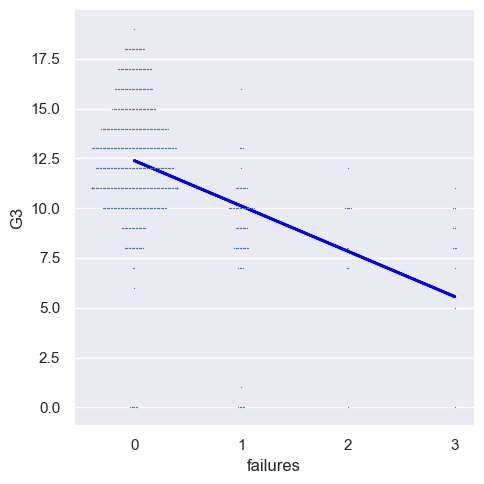

In [129]:
# Plot outputs
#plt.scatter(X_test_subset_1, y_test_subset_1, color="black")

sns.catplot(data=df_line_fit_1_drop2, x="failures", y="G3", kind="swarm", s = .9)
plt.plot(X_test_subset_1, y_pred_subset_1, color="blue", linewidth=2)


In [130]:
scores_LinReg_1 = cross_val_score(model_LinReg_1, X_train_subset_1, y_train_subset_1, cv=cv, scoring = 'neg_mean_absolute_error')

-scores_LinReg_1

array([2.10654776, 2.11254686, 2.08278896, 2.4119659 , 2.21840223])

In [131]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (-scores_LinReg_1.mean(), scores_LinReg_1.std()))

2.19 accuracy with a standard deviation of 0.12


In [132]:
model_LinReg = linear_model.LinearRegression()

In [133]:
# Keep selected subset of columns only
# Improve interpretabliltiy by running the model with only the important features

my_cols = ['failures','Medu','G3']
df_subset = df[my_cols].copy()

df_subset.head(10)

,failures,Medu,G3
0,0,4,11
1,0,1,11
2,0,1,12
3,0,4,14
4,0,3,13
5,0,4,13
6,0,2,13
7,0,4,13
8,0,3,17
9,0,3,13


In [134]:
df_subset['failures'].value_counts()

0    549
1     70
2     16
3     14
Name: failures, dtype: int64

In [135]:
df_subset['Medu'].value_counts()

2    186
4    175
1    143
3    139
0      6
Name: Medu, dtype: int64

In [136]:
# Separate target from predictors

y_subset = df_subset.G3
X_subset = df_subset.drop(['G3'], axis=1)


# Divide data into training and test subsets

X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y_subset, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)


In [137]:
X_train_subset.head(10)

,failures,Medu
27,0,4
43,0,2
130,0,3
294,0,2
136,0,2
211,0,3
578,1,3
541,0,2
463,0,2
170,3,1


In [138]:
X_train.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences_bin
27,GP,M,15,U,GT3,T,4,2,health,services,...,yes,yes,no,2,2,4,2,4,1,1
43,GP,M,15,U,GT3,T,2,2,services,services,...,yes,yes,no,5,4,1,1,1,1,1
130,GP,F,15,R,GT3,T,3,4,services,teacher,...,yes,yes,yes,4,2,2,2,2,5,1
294,GP,F,18,R,GT3,T,2,2,other,other,...,yes,no,no,3,2,3,1,1,5,2
136,GP,M,16,U,GT3,T,2,1,at_home,other,...,yes,no,no,3,2,1,1,1,2,2
211,GP,M,16,R,LE3,T,3,3,teacher,other,...,yes,yes,no,3,3,4,3,5,3,3
578,MS,M,17,U,GT3,T,3,3,health,other,...,yes,yes,no,4,5,4,2,3,3,2
541,MS,F,17,R,GT3,T,2,2,other,other,...,yes,no,no,5,1,3,1,1,5,1
463,MS,F,15,R,LE3,T,2,2,other,other,...,yes,no,no,4,4,3,2,2,5,2
170,GP,F,18,R,GT3,T,1,1,at_home,other,...,yes,no,no,5,2,5,1,5,4,3


In [139]:
model_LinReg.fit(X_train_subset, y_train_subset)


LinearRegression()

In [140]:
# Make predictions using the testing set
y_pred_subset = model_LinReg.predict(X_test_subset)

In [141]:
# The coefficients
print("Coefficients: \n", model_LinReg.coef_)

Coefficients: 
 [-2.10902039  0.54863313]


In [142]:
# The mean absolute error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test_subset, y_pred_subset))

Mean absolute error: 2.16


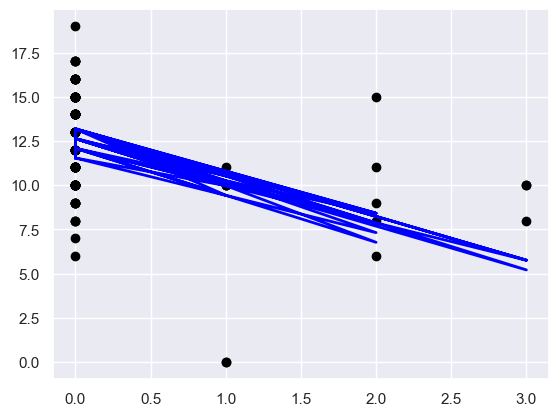

In [143]:
# Plot outputs
plt.scatter(X_test_subset['failures'], y_test_subset, color="black")
plt.plot(X_test_subset['failures'], y_pred_subset, color="blue", linewidth=2)


In [144]:
scores3 = cross_val_score(model_LinReg, X_train_subset, y_train_subset, cv=cv, scoring = 'neg_mean_absolute_error')

-scores3

array([1.99258358, 1.98413143, 2.06750377, 2.40838067, 2.08947683])

In [145]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (-scores3.mean(), scores3.std()))

2.11 accuracy with a standard deviation of 0.16


In [146]:
## As a comparison, what if predict every student just scores the average?
def Average(lst):
    return sum(lst) / len(lst)

avg = Average(y_train)

display(avg)


11.86897880539499

In [147]:
ones_length_test = [1]*len(y_test)

In [148]:
y_pred_avg = [x * avg for x in ones_length_test]

y_pred_avg

[11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,
 11.86897880539499,


In [149]:
# The mean absolute error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred_avg))

Mean absolute error: 2.29


In [156]:
## Rethink: Let's test which variables are correlated with G3 to use in linear regression

df_dropped = df_full.drop(['G1','G2'], axis=1)

In [157]:
df_dropped.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,absences_bin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,4,11,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,2,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,6,12,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,1,1,5,0,14,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,1,2,5,0,13,1
5,GP,M,16,U,LE3,T,4,3,services,other,...,no,5,4,2,1,2,5,6,13,3
6,GP,M,16,U,LE3,T,2,2,other,other,...,no,4,4,4,1,1,3,0,13,1
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,no,4,1,4,1,1,1,2,13,2
8,GP,M,15,U,LE3,A,3,2,services,other,...,no,4,2,2,1,1,1,0,17,1
9,GP,M,15,U,GT3,T,3,4,other,other,...,no,5,5,1,1,1,5,0,13,1


In [158]:
corr_matrix = df_dropped.corr()

corr_matrix

C:\Users\jboak\AppData\Local\Temp\ipykernel_5484\2470748558.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_dropped.corr()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3,absences_bin
age,1.000000,-0.107832,-0.121050,0.034490,-0.008415,0.319968,-0.020559,-0.004910,0.112805,0.134768,0.086357,-0.008750,0.149998,-0.106505,0.118466
Medu,-0.107832,1.000000,0.647477,-0.265079,0.097006,-0.172210,0.024421,-0.019686,0.009536,-0.007018,-0.019766,0.004614,-0.008577,0.240151,-0.007772
Fedu,-0.121050,0.647477,1.000000,-0.208288,0.050400,-0.165915,0.020256,0.006841,0.027690,0.000061,0.038445,0.044910,0.029859,0.211800,0.027326
traveltime,0.034490,-0.265079,-0.208288,1.000000,-0.063154,0.097730,-0.009521,0.000937,0.057454,0.092824,0.057007,-0.048261,-0.008149,-0.127173,0.032423
studytime,-0.008415,0.097006,0.050400,-0.063154,1.000000,-0.147441,-0.004127,-0.068829,-0.075442,-0.137585,-0.214925,-0.056433,-0.118389,0.249789,-0.097438
failures,0.319968,-0.172210,-0.165915,0.097730,-0.147441,1.000000,-0.062645,0.108995,0.045078,0.105949,0.082266,0.035588,0.122779,-0.393316,0.088836
famrel,-0.020559,0.024421,0.020256,-0.009521,-0.004127,-0.062645,1.000000,0.129216,0.089707,-0.075767,-0.093511,0.109559,-0.089534,0.063361,-0.104598
freetime,-0.004910,-0.019686,0.006841,0.000937,-0.068829,0.108995,0.129216,1.000000,0.346352,0.109904,0.120244,0.084526,-0.018716,-0.122705,-0.050992
goout,0.112805,0.009536,0.027690,0.057454,-0.075442,0.045078,0.089707,0.346352,1.000000,0.245126,0.388680,-0.015741,0.085374,-0.087641,0.103008
Dalc,0.134768,-0.007018,0.000061,0.092824,-0.137585,0.105949,-0.075767,0.109904,0.245126,1.000000,0.616561,0.059067,0.172952,-0.204719,0.106872


In [161]:
# I chose failures and Medu because: 
# 1) highly correlated with G3 and 
# 2) Had a nontrivial range, failures from 0 to 3 and Medu from 0 to 4

# Notice that absences has a higher correlation with G3 than absences_bin. 
# This seems to imply that absences_bin will be a worse predictor over absences, however
#     absences_bin does not have rare categories. 
#     This means that the training set will have enough representatives in each category.
#     I suspect that trees are sensitive to rare categories, but regression might be more robust to it.

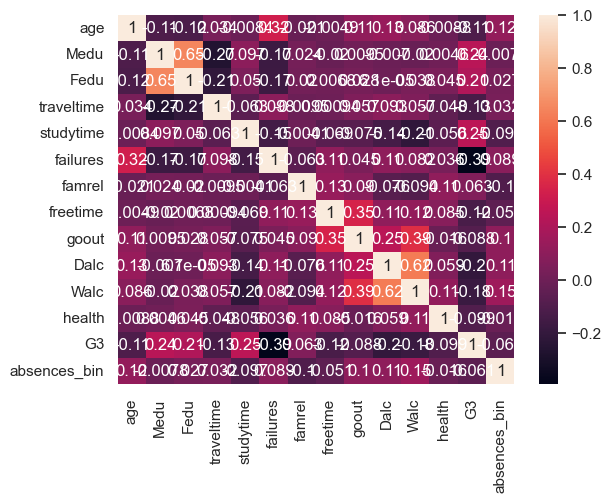

In [154]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [155]:
# Ordinal variables may be treated as continuous and used in linear regression:
# https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf
